# Header

In [1]:
import numpy as np
import random
import numpy.linalg as ln
from random import randint
import scipy.optimize as so
from math import sqrt
from time import time_ns as now
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import partition

import os
from time import time_ns as now
!pip install tabulate
from tabulate import tabulate
!pip install memory_profiler
%load_ext memory_profiler
from memory_profiler import memory_usage


import signal
from contextlib import contextmanager
import warnings
warnings.filterwarnings("ignore")

eps_to_delete = 1e-6


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Help functions

In [2]:
# Control block

arithmetic = 0

def calculate_arithmetic(runnable):
    global arithmetic
    arithmetic = 0
    return { "ans": runnable(), "arithmetic": arithmetic }


In [3]:

def add_eps(pos, x_num, eps):
    global arithmetic
    arithmetic += 1
    poseps = [xi for xi in pos]
    poseps[x_num] += eps
    return np.array(poseps)


def differentiate(fun, x_num, pos, eps = 1e-4):
    global arithmetic
    arithmetic += 2
    return (fun(add_eps(pos, x_num, eps)) - fun(pos)) / eps


def differentiate_fun(fun, x_num, eps = 1e-4):
    return lambda pos: differentiate(fun, x_num, pos, eps)


def count_grad(r, pos):
    return np.array([differentiate(r, i, pos) for i in range(len(pos))])


def count_hess(fun, pos):
    n = len(pos)
    grad = [differentiate_fun(fun, i) for i in range(n)]
    return np.array([count_grad(grad[i], pos) for i in range(n)])


def count_j(r, pos):
    return np.array([count_grad(ri, pos) for ri in r])


def count_r(r, pos):
    return np.array([ri(pos) for ri in r])


def count_f(rs, pos):
    global arithmetic
    res = 0
    for i in range(len(rs)):
        arithmetic += 2
        res += rs[i](pos) ** 2
    return res


def count_f_fun(rs):
    return lambda pos: count_f(rs, pos)


def gradient_advanced(f, pos, eps=0.01):
    global arithmetic
    arr = np.array([0] * len(pos), float)
    for i in range(len(pos)):
        arithmetic += 7
        pos[i] += eps
        arr[i] = f(pos)
        pos[i] -= 2 * eps
        arr[i] = (arr[i] - f(pos)) / (2 * eps)
        pos[i] += eps
    return arr


# Gauss-Newton

In [4]:
from numpy.core.fromnumeric import partition

def gauss(rs, n, sp=None, eps=1e-6):
    global arithmetic
    if sp == None:
        x = np.array([0] * n, float)
    else:
        x = sp
    k = 0
    for k in range(3000):
        j = count_j(rs, x)
        r = count_r(rs, x)
        arithmetic += len(rs) * (2 * n * n + 3 * n) + n * n * (n + 1)
        p = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(j), j) + np.diag([eps] * n)), np.transpose(j)), r)
        arithmetic += n + 1
        if np.dot(p, p) < eps ** 2:
            break
        arithmetic += 1
        x = x - p
    return x, k + 1


# Dogleg

In [5]:

def calc_p(h, g, b, tr):
    global arithmetic
    arithmetic += len(h)
    pb = -np.matmul(h, g)

    arithmetic += len(pb) + 1
    if np.dot(pb, pb) <= tr ** 2:
        return pb

    arithmetic += 4 * len(g)
    pu = -(np.dot(g, g) / np.dot(g, np.matmul(b, g))) * g

    arithmetic += len(pu)
    npu = np.linalg.norm(pu)

    if npu >= tr:
        arithmetic += 2
        return tr * pu / npu

    arithmetic += 1
    pub = pb - pu

    arithmetic += len(pu) + 5 + len(pu) + len(pub)
    d = np.dot(pu, pub) ** 2 - (np.dot(pu, pu) - tr ** 2) * np.dot(pub, pub)

    arithmetic += 2 * len(pu) + 4
    tau = (-np.dot(pu, pub) + d ** 0.5) / np.dot(pub, pub)

    arithmetic += 2
    return pu + tau * pub


def dogleg(func, grad_help, sp, start_tr=1.0, max_tr=100.0, maxiter=100, eps=1e-3):
    global arithmetic
    x = sp
    tr = start_tr
    k = 0
    while True:
        g = grad_help(func, x)

        arithmetic += len(g) + 1
        if np.linalg.norm(g) < eps:
            break

        b = count_hess(func, x)

        mn = b[0][0]

        for i in range(len(b)):
            arithmetic += 1
            mn = min(mn, b[i][i])
        arithmetic += 2
        tau = min(0, mn) + 1e-3

        for i in range(1000):
            try:
                arithmetic += len(b) ** 3
                np.linalg.cholesky(b)
                break
            except np.linalg.LinAlgError:
                arithmetic += len(b) + 2
                b += np.diag([tau] * len(b))
                tau *= 2.0

        arithmetic += len(b) ** 3
        h = np.linalg.inv(b)

        p = calc_p(h, g, b, tr)

        arithmetic += 4 + len(g) + len(b) * len(p)
        rho = (func(x) - func(x + p)) / max(1e-10, -np.dot(g, p) - 0.5 * np.dot(p, np.matmul(b, p)))

        arithmetic += len(p)
        norm_p = np.linalg.norm(p)


        if rho < 0.25:
            arithmetic += 1
            tr *= 0.5
        if rho > 0.75 and norm_p >= tr - eps:
            arithmetic += 1
            arithmetic += 2
            tr = min(2.0 * tr, max_tr)

        if rho > 0:
            arithmetic += 1
            x = x + p

        if k >= maxiter:
            break
            
        arithmetic += 1
        k = k + 1

    return x, k


# BFGS

In [6]:

def dichotomy(f, g, pos, dir, lr=0.005, eps=0.001):
    global arithmetic
    r = lr
    mn = f(pos)
    while True:
        arithmetic += 2
        tmp = f(pos + dir * r)
        if tmp >= mn:
            break
        mn = tmp
        arithmetic += 1
        r *= 2
    l = 0
    for _ in range(20):
        arithmetic += 8
        m = (r + l) / 2
        if f(pos + (m + eps) * dir) > f(pos + (m - eps) * dir):
            r = m
        else:
            l = m
    return l


def bfgs(f, grad_help, x0, so_line_search=False, limit_memory=False, m=7, maxiter=None, eps=0.1):
    global arithmetic
    if maxiter is None:
        arithmetic += 1
        maxiter = len(x0) * 200

    def grad(x):
        return grad_help(f, x)

    k = 0
    gk = grad(x0)
    n = len(x0)
    xk = x0

    if limit_memory:
        y = np.zeros((m, n))
        ros = np.zeros(m)
        s = np.zeros((m, n))
        alpha = np.zeros(m)
        z = gk
    else:
        I = np.eye(n, dtype=float)
        Hk = I

    arithmetic += len(gk)
    while ln.norm(gk) > eps and k < maxiter:
        if limit_memory:
            pk = -z
        else:
            arithmetic += len(gk)
            pk = -np.dot(Hk, gk)

        if so_line_search:
            alpha_k = so.line_search(f, grad, xk, pk)[0]
        else:
            alpha_k = dichotomy(f, grad, xk, pk)

        arithmetic += 4
        next_x = xk + alpha_k * pk
        sk = next_x - xk
        xk = next_x

        gk_next = grad(xk)
        yk = gk_next - gk
        gk = gk_next

        arithmetic += 1 + len(yk)
        ro = 1.0 / (np.dot(yk, sk))

        if limit_memory:
            arithmetic += 3
            s[k % m] = sk
            y[k % m] = yk
            ros[k % m] = ro
            q = gk
            arithmetic += 4
            for i in reversed(range(max(0, k - m + 1), k + 1)):
                arithmetic += 7 + 2 * len(q)
                alpha[i % m] = ros[i % m] * np.dot(s[i % m], q)
                q = q - alpha[i % m] * y[i % m]
            arithmetic += 9 + len(yk) * 2
            gamma_k = np.dot(s[k % m], y[k % m]) / np.dot(y[k % m], y[k % m])
            z = gamma_k * q
            for i in range(max(0, k - m + 1), k + 1):
                arithmetic += 6 + 3 * len(z)
                beta = np.dot(ros[i % m], np.dot(y[i % m], z))
                z = z + s[i % m] * (alpha[i % m] - beta)

        else:
            arithmetic += 6 * n
            A1 = I - ro * sk[:, np.newaxis] * yk[np.newaxis, :]
            A2 = I - ro * yk[:, np.newaxis] * sk[np.newaxis, :]
            arithmetic += len(A1) + len(A2) + len(sk) ** 2 + len(sk) ** 3 + 2
            Hk = np.dot(A1, np.dot(Hk, A2)) + (ro * (sk @ np.transpose(sk)))

        arithmetic += 1 + len(gk)
        k += 1

    return xk, k


# LBFGS

In [7]:

def lbfgs(f, grad_help, x0, so_line_search=False, m=7, maxiter=None, eps=0.01):
    return bfgs(f, grad_help, x0, so_line_search, limit_memory=True, m=7, maxiter=maxiter, eps=eps)


def generate_function(n: int, k: float):
    values = [random.uniform(1.0, k) for _ in range(n - 2)]
    values.extend([1.0, k])
    values.sort()
    d = np.diag(values)
    m = np.random.rand(n, n)
    q, _ = np.linalg.qr(m)
    m = np.matmul(np.matmul(q, d), np.transpose(q))
    return [lambda x: x @ m @ x,
            lambda f, x: dichotomy(f=f, g=None, pos=x, dir=np.diag(np.full(n, -2)) @ m @ x)]


# Tests

In [8]:

class TestCase:
    def __init__(self, n: int, points, rs, start_point):
        self.n = n
        self.points = points
        self.rs = rs
        self.start_point = start_point

    def to_sum(self):
        return lambda x: sum([(r(x) ** 2) for r in self.rs])

    def squares(self):
        return [lambda x: (r(x) ** 2) for r in self.rs]

    def calculate_delta(self, ans):
        return abs(ans - self.to_sum(self.points))

    def __str__(self):
        return str(len(self.points)) + '\n' + ' '.join(map(str, self.start_point)) + '\n' + '\n'.join(map(lambda x: ' '.join(map(str, x)), self.points))


class TestMethod:
    def _generate(f, eps):
        def get_by_point(point):
            return lambda args: (f(point[0], args) - point[1] + eps)
        return lambda points: [get_by_point(i) for i in points]

    # rsp -- recommended start point
    def __init__(self, n: int, name: str, fbase, rsp, left=-10, right=10, eps=1e-7):
        self.n = n
        self.name = name
        self.rsp = rsp
        self.left = left
        self.right = right
        self.fbase = fbase
        self.fun = TestMethod._generate(fbase, eps)

    def substitute_beta_to_fbase(self, beta):
        return lambda x: self.fbase(x, beta)

    def init_by_random_points(self, m=100, eps=1e-2):
        points = [[random.uniform(self.rsp[i] - eps, self.rsp[i] + eps) for i in range(self.n)] for _ in range(m)]
        return TestCase(self.n, points, self.fun(points), self.rsp)

    def generate_along_ansfunction(self, beta, m=100, delta=1):
        tmpfun = lambda x: self.fbase(x, beta)
        points = []
        for _ in range(m):
            x = random.uniform(self.left, self.right)
            y = tmpfun(x)
            points.append([x, y + random.uniform(-1, 1) * delta / 2])
        return TestCase(self.n, points, self.fun(points), beta)

    # внимание: answers -- массив из ответов, оптимизирующие методы возвращают tuple(ans, cnt)
    # (assuming save -> separated)
    def draw_funcs(self, points, answers, labels, save=False, separated=False, show_first=False):
        colours = ['b', 'y', 'g', 'r', 'm']
        xs = [p[0] for p in points]
        ys = [p[1] for p in points]
        X = np.linspace(self.left, self.right, 50 * (self.right - self.left))
        i = 0
        if not separated or save:
            if show_first:
                ff = self.substitute_beta_to_fbase(answers[i])
                plt.plot(X, np.vectorize(ff)(X), label=labels[i], color=colours[i])
                plt.scatter(xs, ys)
                plt.title(self.name + ', ' + labels[i])
                plt.legend()
                plt.show()
            i = 1
        for i in range(i, len(answers)):
            ff = self.substitute_beta_to_fbase(answers[i])
            plt.plot(X, np.vectorize(ff)(X), label=labels[i], color=colours[i])
            if separated:
                plt.scatter(xs, ys)
                plt.title(self.name + ', ' + labels[i])
                plt.legend()
                if save:
                    plt.savefig(self.name.lower() + '/' + labels[i].lower() + '.jpg')
                    plt.clf()
                else:
                    plt.show()
        if not separated and not save:
            plt.title(self.name)
            plt.scatter(xs, ys)
            plt.legend()
            plt.show()

    def draw_func(self, points, answer, label, save=False, separated=False, show_first=False):
        return self.draw_funcs(points, [answer], [label], save=save, separated=separated, show_first=show_first)

DanWood = TestMethod(2, 'DanWood', lambda x, b: b[0] * (x ** b[1]), [1e0, 5e0], left=0, right=2)

Misra1d = TestMethod(2, 'Misra1d', lambda x, b: b[0] * b[1] * x / (1 + (b[1] * x) ** 2), [5e2, 1e-4], left=1)

Sincos = TestMethod(2, 'Sincos', lambda x, ab: ab[0] * np.sin(x) + ab[1] * np.cos(x), [0, 0])

Sin = TestMethod(2, 'Sin', lambda x, c: c[0] * np.sin(x * c[1]), [1, 1])

Cos = TestMethod(2, 'Cos', lambda x, c: c[0] * np.cos(x * c[1]), [1, 1])

def polynomial_test(deg, l=-10, r=10, name=None):
    if name == None:
        name = 'Deg' + str(deg)
    return TestMethod(deg + 1, name, lambda x, c: sum([c[i] * (x ** (deg - i)) for i in range(deg + 1)]), [1] + [0] * deg, l, r)

Linear = polynomial_test(1, name='Linear')

Quadratic = polynomial_test(2, -5, 5, name='Quadratic')

Deg3 = polynomial_test(3, -2, 2)

Deg4 = polynomial_test(4, -2, 2)

Deg5 = polynomial_test(5, -1, 1)

LinearExt = TestMethod(5, 'LinearExt', lambda x, c: (c[0] - c[1] / c[3] * x) * c[4] / c[2], [-1, 1, 1, 1, 1])

def linearFakeArgs(n = 2):
    return TestMethod(n, 'LinearArgs_' + str(n), lambda x, c: c[0] * x + c[1], [1, 0] + [0] * (n - 2))


## Запуск с TL

In [9]:

class TimeoutException(Exception): pass

@contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

# tl in seconds
def run_with_tl(message, test_case, runnable, tl=2):
    print(message, end=' ')
    try:
        with time_limit(tl):
            start = now()
            ans = runnable()
            time = now() - start
            print({"ans": ans, "time": time, "func_value": test_case.to_sum()(ans[0])})
    except TimeoutException as e:
        print('Time limit')
    except Exception as e:
        print('Failed with', type(e), ':', str(e))


def test_all(test_group):
    for method in test_group:
        print(method.name)
        test_case = method.init_by_random_points(m=100)
        f = test_case.to_sum()
        # print(test_case.points)
        run_with_tl('\tBFGS   :', test_case, lambda: bfgs(f, gradient_advanced, method.rsp))
        run_with_tl('\tLBFGS  :', test_case, lambda: lbfgs(f, gradient_advanced, method.rsp))
        run_with_tl('\tGauss  :', test_case, lambda: gauss(test_case.rs, test_case.n))
        run_with_tl('\tDogLeg :', test_case, lambda: dogleg(test_case.rs, test_case.n))
        print()


## Запуск и отрисовка

In [10]:

OptimizationMethods = {
    "Gauss": lambda tc: gauss(tc.rs, tc.n, tc.start_point),
    "Dogleg": lambda tc: dogleg(tc.to_sum(), count_grad, tc.start_point),
    "BFGS": lambda tc: bfgs(tc.to_sum(), gradient_advanced, tc.start_point), 
    "LBFGS": lambda tc: lbfgs(tc.to_sum(), gradient_advanced, tc.start_point),
}

# да копипаста, так и задумано
def test_with_tl_with_f(f, runnable, tl=1):
    try:
        with time_limit(tl):
            st = now()
            arithm_ans = calculate_arithmetic(runnable)
            ans, steps = arithm_ans["ans"]
            time = now() - st
        mem = max(memory_usage(runnable))
        return {"present": True, "answer": ans, "time (ns)": time, "memory (MB)": mem, "steps": steps, "arithmetic": arithm_ans["arithmetic"], "func_value": f(ans)}
    except TimeoutException as e:
        return {"present": False, "answer": None, "cause": "TL"}
    except Exception as e:
        return {"present": False, "answer": None, "cause": str(e)}


def test_with_tl(test_case, runnable, tl=1):
    return test_with_tl_with_f(test_case.to_sum(), runnable, tl=tl)


Новые тесты

In [14]:

def test_with_testcase(method, test_case, start_beta, tl=1, delta=10, save=False, separated=False, show_first=False, log_ans=True):
    answers = [start_beta]
    labels = ["Start"]
    table = [[method.name]]
    for (name, optmethod) in OptimizationMethods.items():
        ans = {"name": name}
        ans.update(test_with_tl(test_case, lambda: optmethod(test_case), tl=tl))
        if log_ans:
            print(ans)
        if ans["present"]:
            labels.append(name)
            answers.append(ans["answer"])
            ans.pop("present")
            ans.pop("answer")
            if len(table) == 1:
                table.append(list(ans.keys()))
            table.append(list(ans.values()))
    if log_ans:
        print(answers)
    method.draw_funcs(test_case.points, answers, labels, save=save, separated=separated, show_first=show_first)
    return tabulate(table, tablefmt="tsv", headers='firstrow')


def test_and_draw(method, start_beta, m=100, tl=1, delta=10, save=False, separated=False, show_first=False, log_ans=True):
    test_case = method.generate_along_ansfunction(beta=start_beta, m=m, delta=delta)
    return test_with_testcase(method, test_case, start_beta, tl, delta, save=save, separated=separated, show_first=show_first, log_ans=log_ans)


# local_delta = 10
# for method in Trigonom_tests:
#     test_and_draw(method,
#                 # start_beta=[1, 1],
#                 start_beta=[(method.rsp[i] + random.uniform(-1, 1) * local_delta) for i in range(method.n)],
#                 m=100,
#                 tl=2,
#                 delta=0.1)


In [15]:

# random_sp = { 0 -> rsp, 1 -> rsp+shift, 2 -> random, else -> random_sp }
def search_good_test(method, default_test_case=None, m=10, eps=1e-6, delta=0.1, random_sp=0, log=True, log_ans=True, to_file=False, step=100, tl=1, save=True, separated=True, show_first=False):
    _st = 0
    while True:
        if default_test_case == None:
            sp = method.rsp
            along_sp = method.rsp
            if random_sp == 1:
                for i in range(method.n):
                    sp[i] += random.uniform(-1, 1) * eps
            elif random_sp == 2:
                for i in range(method.n):
                    sp[i] = random.uniform(0, 1) * (method.right - method.left) + method.left
            elif random_sp != 0:
                sp = random_sp
                along_sp = random_sp
            test_case = method.generate_along_ansfunction(along_sp, m, delta)
        else:
            test_case = default_test_case
        fvals = []
        flag = False
        for opt_method in OptimizationMethods:
            res = test_with_tl(test_case, lambda: OptimizationMethods[opt_method](test_case), tl=tl)
            if log:
                print(res)
            if not res["present"]:
                flag = True
                break
            fvals.append(res["func_value"])
        if log:
            print()
        if flag:
            if log and _st != 0 and _st % step == 0:
                print(_st, 'tests failed')
            _st += 1
            if default_test_case == None:
                continue
        fvals = sorted(map(abs, fvals))
        if len(fvals) > 0 and fvals[-1] - fvals[0] < eps:
            if log_ans:
                print(fvals[0])
            path_to_save = method.name.lower()
            if not os.path.exists(path_to_save) and (to_file or save):
                os.mkdir(path_to_save)
            ans = test_with_testcase(method, test_case, test_case.start_point, save=save, separated=separated, show_first=show_first, tl=tl)
            if to_file:
                with open(os.path.join(path_to_save, 'input.tc'), 'w') as file:
                    print(test_case, file=file)
            return ans


# search_good_test(Linear, m=100, eps=0.1, delta=20, random_sp=2, log=True, to_file=True, show_first=True, tl=2, step=1)
# search_good_test(Quadratic, m=100, eps=0.1, delta=15, random_sp=2, log=False, to_file=True, show_first=True, tl=2)
# search_good_test(Deg3, m=100, eps=0.1, delta=5, random_sp=2, log=False, to_file=True, show_first=True)
# search_good_test(Deg4, m=100, eps=0.1, delta=10, random_sp=2, log=False, to_file=True, show_first=True)
# search_good_test(Deg5, m=150, eps=0.1, delta=0.5, random_sp=2, log=False, to_file=True, show_first=True)
# search_good_test(polynomial_test(10, -1, 1), m=100, eps=1, delta=0.5, random_sp=0, log=True, to_file=False, show_first=True, tl=10)
# search_good_test(LinearExt, m=25, eps=1, delta=0.5, random_sp=2, log=True, to_file=True, save=True, show_first=True, tl=3)
# search_good_test(Sincos, m=100, eps=0.01, delta=5, random_sp=2, log=False, to_file=True, show_first=True)
# search_good_test(DanWood, m=30, eps=0.01, delta=4, random_sp=[-2, 1.5], log=False, to_file=True, show_first=True)
# search_good_test(Misra1d, m=30, eps=0.01, delta=2, random_sp=[6.5, 0.5], log=False, to_file=True, show_first=True, tl=2)


## Запуск тестов из файла

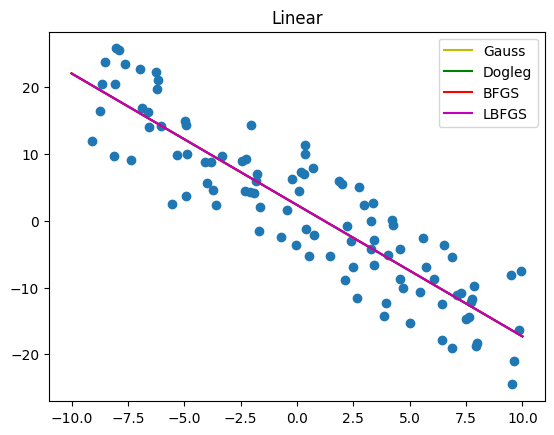

      	         	           	     	          	Linear
name  	time (ns)	memory (MB)	steps	arithmetic	func_value
Gauss 	46112573 	116.7734375	2    	4031      	2752.038733630338
Dogleg	10872051 	116.7734375	1    	93        	2752.0387410055196
BFGS  	48499729 	116.7734375	3    	686       	2752.038734125897
LBFGS 	23925793 	116.7734375	3    	839       	2752.038733630339


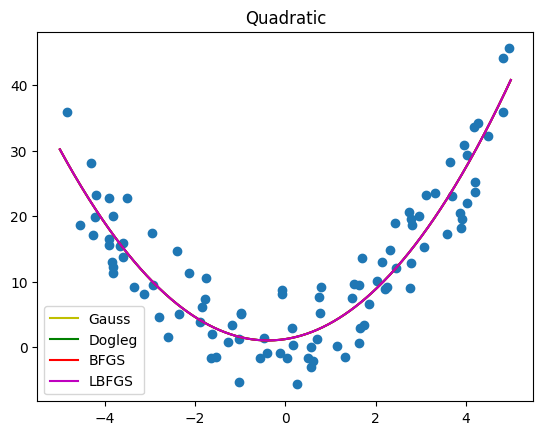

      	         	           	     	          	Quadratic
name  	time (ns)	memory (MB)	steps	arithmetic	func_value
Gauss 	21338080 	124.0234375	2    	7281      	1951.3571317653227
Dogleg	20633393 	124.0234375	1    	194       	1951.3571907815203
BFGS  	83322272 	124.0234375	4    	1074      	1951.357132277978
LBFGS 	44345839 	124.0234375	4    	1275      	1951.3571317653225


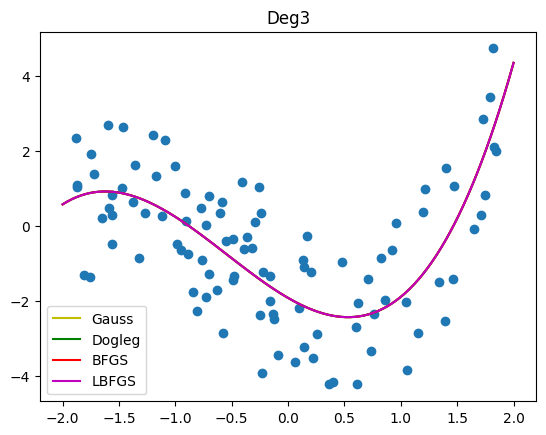

      	         	           	     	          	Deg3
name  	time (ns)	memory (MB)	steps	arithmetic	func_value
Gauss 	12983482 	126.0234375	2    	11371     	164.45657105565394
Dogleg	32138361 	126.0234375	1    	351       	164.45657664134205
BFGS  	115599761	126.0234375	5    	1661      	164.45657263542736
LBFGS 	70211145 	126.0234375	4    	1368      	164.4565710562412


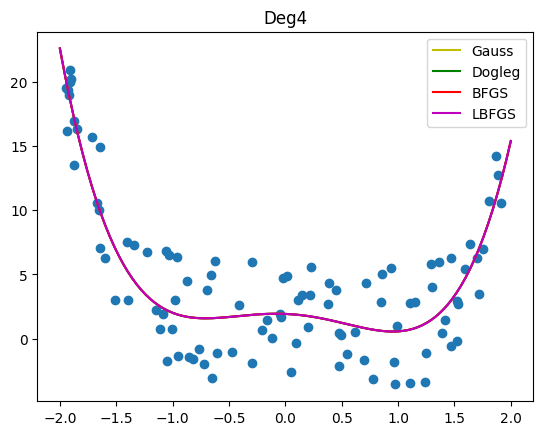

      	         	           	     	          	Deg4
name  	time (ns)	memory (MB)	steps	arithmetic	func_value
Gauss 	18442872 	126.1484375	2    	16313     	762.6349322817663
Dogleg	62079932 	126.1484375	1    	576       	762.6350508050893
BFGS  	187959496	126.1484375	8    	3363      	762.6349346376006
LBFGS 	84323042 	126.1484375	5    	1932      	762.6349322823149


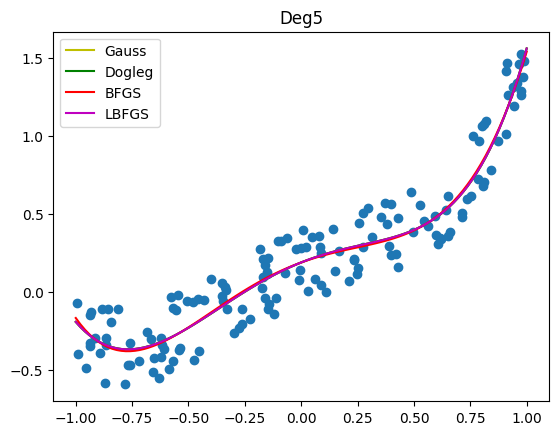

      	         	           	     	          	Deg5
name  	time (ns)	memory (MB)	steps	arithmetic	func_value
Gauss 	42282743 	128.0234375	3    	49379     	3.3596425068868077
Dogleg	134658319	128.0234375	1    	881       	3.3596432095496254
BFGS  	338396388	128.0234375	7    	3813      	3.3692817137011466
LBFGS 	275511682	128.0234375	6    	2620      	3.359642561876159


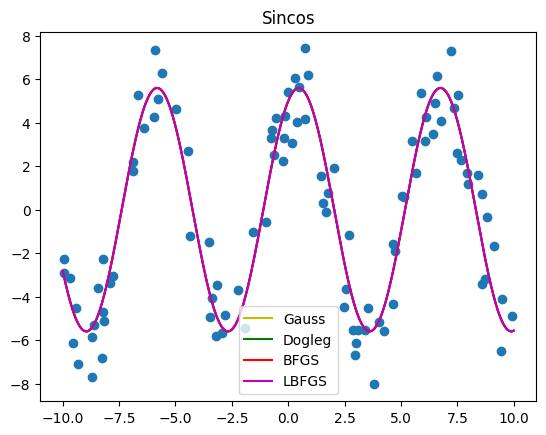

      	         	           	     	          	Sincos
name  	time (ns)	memory (MB)	steps	arithmetic	func_value
Gauss 	6719420  	130.3984375	2    	4031      	190.08914020575253
Dogleg	37421529 	130.3984375	1    	93        	190.0891404580468
BFGS  	90895855 	130.3984375	2    	465       	190.08914032037103
LBFGS 	43787547 	130.3984375	2    	531       	190.08914020575253


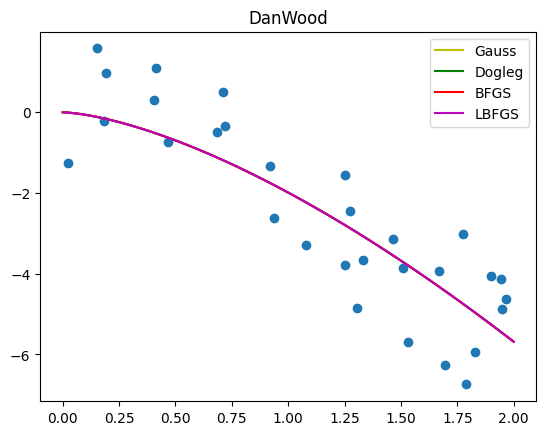

      	         	            	     	          	DanWood
name  	time (ns)	memory (MB) 	steps	arithmetic	func_value
Gauss 	9326223  	130.63671875	14   	8623      	41.176568744907556
Dogleg	2495733  	130.63671875	2    	177       	41.17657306619006
BFGS  	6372912  	130.63671875	2    	468       	41.176568781737004
LBFGS 	5025387  	130.63671875	3    	842       	41.17656912759048


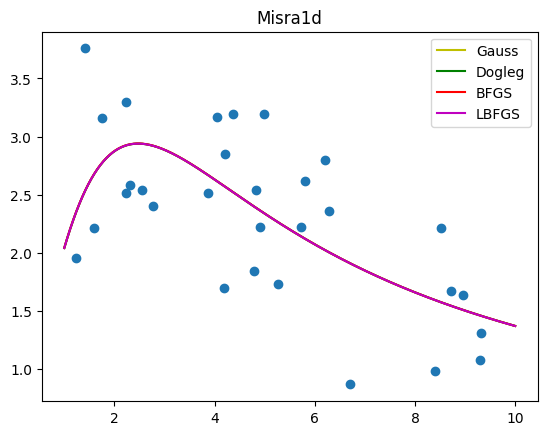

      	         	            	     	          	Misra1d
name  	time (ns)	memory (MB) 	steps	arithmetic	func_value
Gauss 	3742559  	132.38671875	6    	3695      	8.917793557143204
Dogleg	10272966 	132.38671875	5    	430       	8.917794643310083
BFGS  	31862143 	132.38671875	5    	1176      	8.917813024549977
LBFGS 	13092245 	132.38671875	4    	1164      	8.917797353464968


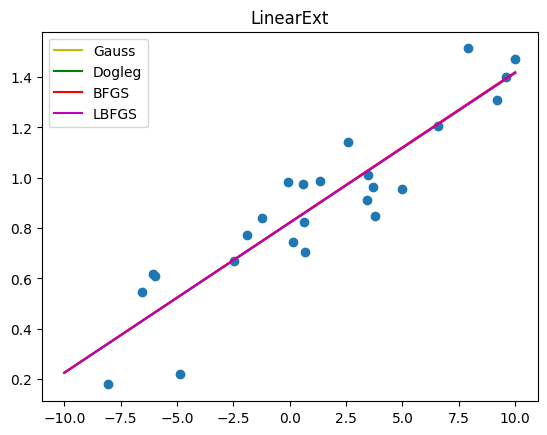

      	         	            	     	          	LinearExt
name  	time (ns)	memory (MB) 	steps	arithmetic	func_value
Gauss 	18104543 	134.63671875	7    	15098     	0.44244435350167527
Dogleg	128383881	134.76171875	13   	11629     	0.44244435373891233
BFGS  	16776319 	134.76171875	2    	900       	0.44253206224057146
LBFGS 	7778723  	134.76171875	3    	1064      	0.44244447810151744


In [12]:

def run_test_from_file(method):
    with open('tests/' + method.name.lower() + '/input.tc', 'r') as f:
        m = int(f.readline())
        sp = [float(i) for i in f.readline().split()]
        points = []
        for i in range(m):
            x, y = map(float, f.readline().split())
            points.append([x, y])
        print(test_with_testcase(method, TestCase(method.n, points, method.fun(points), sp), sp, tl=1000, separated=False, log_ans=False))


Tests = [Linear, Quadratic, Deg3, Deg4, Deg5, Sincos, DanWood, Misra1d, LinearExt]
for test_func in Tests:
    run_test_from_file(test_func)


## Квадратичные функции

In [ ]:

def generate_function(n: int, k: float):
    values = [random.uniform(1.0, k) for _ in range(n - 2)]
    values.extend([1.0, k])
    values.sort()
    d = np.diag(values)
    m = np.random.rand(n, n)
    q, _ = np.linalg.qr(m)
    m = np.matmul(np.matmul(q, d), np.transpose(q))
    return [lambda x: x @ m @ x,
            lambda f, x: np.diag(np.full(n, -2)) @ m @ x]

def run_all_with_tl(method, f, g, name, tl=10):
    ans = {"method": name}
    ans_ar = calculate_arithmetic(lambda: test_with_tl_with_f(f, lambda: method(f, g, [1] * n), tl=tl))
    ans.update(ans_ar["ans"])
    ans.update({"arithm": ans_ar["arithmetic"]})
    if not ans["present"]:
        raise ValueError()
    ans.pop("answer")
    ans.pop("present")
    return list(ans.values())

    
tcnt = 0
while tcnt < 1:
    n, k = 2500, 10
    f, _ = generate_function(n, k)
    try:
        print(k)
        # print(run_all_with_tl(dogleg, f, count_grad, "dogleg", tl=100))
        print(run_all_with_tl(bfgs, f, gradient_advanced, "bfgs", tl=60))
        print(run_all_with_tl(lbfgs, f, gradient_advanced, "lbfgs", tl=60))
        print()
        tcnt += 1
    except ValueError:
        print("aaa")
        continue
